<a href="https://colab.research.google.com/github/Kartheek77/2D-FINITE-ELEMENT-TRANSIENT-HEAT-CONDUCTION-CODE/blob/master/M1_AVC_LINEAR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import warnings
import time
warnings.filterwarnings("ignore")

from tqdm import tqdm
from tqdm.notebook import tqdm
from matplotlib import pyplot as plt 
from sklearn.model_selection import train_test_split 
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import cross_val_score
import numpy as np
import pandas as pd
pd.set_option("display.max_columns", None)
import seaborn as sns
#sns.set(rc={'figure.figsize':(11.7,8.27)})

### READING THE DATASET

In [2]:
df1 = pd.read_csv('MMM_data.csv')
print(df1.shape)
df1.head(10)
df1 = df1[df1['YEAR']==2017]

(107299, 61)


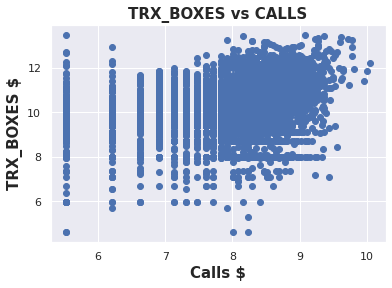

In [3]:
import matplotlib.pyplot as plt

df_hcp_month1 = df1.groupby(['RLYP_ID']).sum()
y = np.log(df_hcp_month1['TRX_BOXES']*3000)
x = np.log(df_hcp_month1['C0']*250)

plt.xlabel('Calls $',fontweight="bold",size=15)
plt.ylabel('TRX_BOXES $',fontweight="bold",size=15)
  
plt.title('TRX_BOXES vs CALLS',fontweight ="bold",size=15)


plt.scatter(x, y)
plt.show()

In [4]:
df2 = df1[['RLYP_ID','YEAR','MONTH','TRX_BOXES','Sales1', 'Sales2', 'Sales3',  'C0', 'C1', 'C2', 'C3', 'S0', 'S1', 'S2', 'S3', 'E0', 'E1', 'E2', 'E3', 'SP0','SP1', 'SP2', 'SP3']]

# EDA

## Dataset description

In [5]:
df2[['TRX_BOXES','C0','S0','E0','SP0']].describe()

,TRX_BOXES,C0,S0,E0,SP0
count,55932.000000,55932.000000,55932.000000,55932.000000,55932.000000
mean,1.378106,1.346653,0.937710,0.097404,0.013659
std,2.292531,1.260111,3.209567,0.651436,0.116841
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.000000,1.000000,0.000000,0.000000,0.000000
75%,2.000000,2.000000,0.000000,0.000000,0.000000
max,42.300000,17.000000,112.000000,109.000000,2.000000


## Correlations before rolling up

import seaborn as sns
sns.heatmap(df2[['C0','S0','E0','SP0','TRX_BOXES']].corr(),annot=True)

## Rolling up the data upto hcp level

In [6]:
df3 = df2.groupby(['RLYP_ID'])[['C0','S0','E0','SP0','TRX_BOXES']].sum().reset_index()

In [7]:
df3.head()

,RLYP_ID,C0,S0,E0,SP0,TRX_BOXES
0,100000039,2,24,0,0,73.500000
1,100000053,3,0,0,0,7.400000
2,100000054,0,0,0,0,1.000000
3,100000057,2,0,0,0,1.333333
4,100000074,10,4,3,0,5.000000


In [8]:
#df2[df2['RLYP_ID']==100000039].head(20)

## Correlations after rolling up

sns.heatmap(df3[['C0','S0','E0','SP0','TRX_BOXES']].corr(),annot=True)

## Computing Total Promotions

In [9]:
df3['Total_Promotions'] = df3['C0']+df3['S0']+df3['E0']+df3['SP0']

In [10]:
df3.head()

,RLYP_ID,C0,S0,E0,SP0,TRX_BOXES,Total_Promotions
0,100000039,2,24,0,0,73.500000,26
1,100000053,3,0,0,0,7.400000,3
2,100000054,0,0,0,0,1.000000,0
3,100000057,2,0,0,0,1.333333,2
4,100000074,10,4,3,0,5.000000,17


## Filtering the hcps with total zero promotions and non zero total promotions

In [11]:
df4 = df3[df3['Total_Promotions']==0]
df5 = df3[df3['Total_Promotions']!=0]

## Correlations after removing hcp's with zero total promotions

import seaborn as sns
sns.heatmap(df5.drop(columns=['RLYP_ID','Total_Promotions']).corr(),annot=True)

In [12]:
len(df3)

7734

In [13]:
len(df5)

6272

In [14]:
len(df4)

1462

## Sum of trx's of hcp's with zero total promotions

In [15]:
np.sum(df4['TRX_BOXES'])

5330.233333333334

## Number of hcps with non zero total promotions

In [16]:
print(len(df5))
df5.head()

6272


,RLYP_ID,C0,S0,E0,SP0,TRX_BOXES,Total_Promotions
0,100000039,2,24,0,0,73.500000,26
1,100000053,3,0,0,0,7.400000,3
3,100000057,2,0,0,0,1.333333,2
4,100000074,10,4,3,0,5.000000,17
5,100000110,11,0,1,0,1.000000,12


## Sum of trx's of hcp's with non zero total promotions

In [17]:
np.sum(df5['TRX_BOXES'])

71749.96666666667

## Distribution of calls

In [18]:
#sns.displot(df5, x="C0",discrete=True)

In [19]:
print('min Calls:',np.min(df5['C0']))
print('max Calls:',np.max(df5['C0']))
print('Number of calls at 99 percentile:',np.percentile(df5['C0'], 99))

min Calls: 0
max Calls: 93
Number of calls at 99 percentile: 45.0


## Distribution of samples

In [20]:
#sns.displot(df5, x="S0",discrete=True)

In [21]:
#min and max of Samples
print('min Samples:',np.min(df5['S0']))
print('max Samples:',np.max(df5['S0']))
print('Number of Samples at 99 percentile:',np.percentile(df5['S0'], 99))

min Samples: 0
max Samples: 264
Number of Samples at 99 percentile: 76.0


## distribution of Events

In [22]:
#sns.displot(df5, x="E0",discrete=True)

In [23]:
#min and max of Events
print('min Events:',np.min(df5['E0']))
print('max Events:',np.max(df5['E0']))
print('Number of Events at 99 percentile:',np.percentile(df5['E0'], 99))

min Events: 0
max Events: 116
Number of Events at 99 percentile: 13.0


## Distribution of Speaker Program

In [24]:
#sns.displot(df5, x="SP0",discrete=True)

In [25]:
#min and max of SP
print('min No of Speaker Program:',np.min(df5['SP0']))
print('max No of Speaker Program:',np.max(df5['SP0']))
print('No of Speaker Program at 99 percentile:',np.percentile(df5['SP0'], 99))

min No of Speaker Program: 0
max No of Speaker Program: 4
No of Speaker Program at 99 percentile: 1.0


### Missing and Total trx after clippling on Calls

In [26]:
t1 = df5[df5['C0']>70]
print('missing trxs: ',np.sum(t1['TRX_BOXES']))
print('total trxs:',np.sum(df5['TRX_BOXES']))

missing trxs:  624.3999999999999
total trxs: 71749.96666666667


### Missing and Total trx after clippling on Samples

In [27]:
t1 = df5[df5['S0']>136]
print('missing trxs: ',np.sum(t1['TRX_BOXES']))
print('total trxs:',np.sum(df5['TRX_BOXES']))

missing trxs:  1364.0999999999997
total trxs: 71749.96666666667


### Missing and Total trx after clippling on Events

In [28]:
t1 = df5[df5['E0']>20]
print('missing trxs: ',np.sum(t1['TRX_BOXES']))
print('total trxs:',np.sum(df5['TRX_BOXES']))

missing trxs:  174.4
total trxs: 71749.96666666667


### Missing and Total trx after clippling on Speaker Programs

In [29]:
t1 = df5[df5['SP0']>3]
print('missing trxs: ',np.sum(t1['TRX_BOXES']))
print('total trxs:',np.sum(df5['TRX_BOXES']))

missing trxs:  22.0
total trxs: 71749.96666666667


# Modelling

### Filtering out the hcps

In [30]:
df6 = df5[(df5['C0']<=45)&(df5['S0']<=76)&(df5['E0']<=13)]
print('total trx after  filtering:',np.sum(df6['TRX_BOXES']))
print('total trx before filtering:',np.sum(df5['TRX_BOXES']))

total trx after  filtering: 64248.53333333333
total trx before filtering: 71749.96666666667


In [31]:
# df6 = df5[(df5['C0']<=100)&(df5['S0']<=150)&(df5['E0']<=20)]#&(df5['SP0']<=3)]
# df6.head()

In [32]:
print(len(df6))
df6 = df6[df6['TRX_BOXES']>0]
print(len(df6))

6112
4715


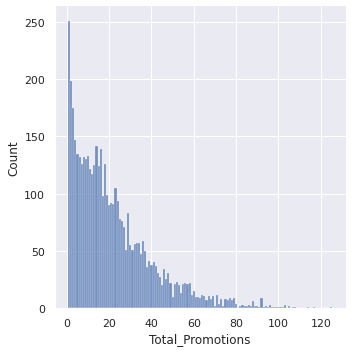

In [33]:
sns.displot(df6, x="Total_Promotions",discrete=True)

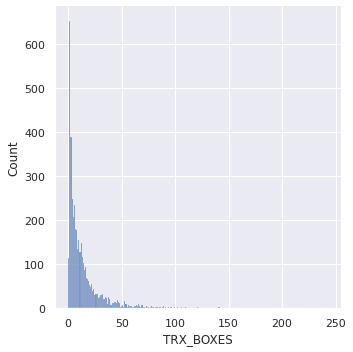

In [34]:
sns.displot(df6, x="TRX_BOXES",discrete=True)

In [35]:
df6.columns

Index(['RLYP_ID', 'C0', 'S0', 'E0', 'SP0', 'TRX_BOXES', 'Total_Promotions'], dtype='object')

In [36]:
#df6['buckets_trx_boxes'] = np.where(df6['decile_trx_boxes']>=6,'BIG',np.where((df6['decile_trx_boxes']<6)&(df6['decile_trx_boxes']>=1),'MEDIUM','SMALL'))

In [37]:
#df6[j].fillna(0,inplace = True)
for col in ['C0', 'S0', 'E0', 'SP0', 'TRX_BOXES', 'Total_Promotions']:
  df6 = df6.sort_values(by = [col], ascending = False)
  decile = []
  col_sum = np.sum(df6[[col]])/10
  t = 0
  for r, i in df6.iterrows():
    t = t + i[[col]]
    dec = 10-int((t/col_sum))
    decile.append(dec)
  df6['decile_'+col] = decile

In [38]:
df6.head(2)

,RLYP_ID,C0,S0,E0,SP0,TRX_BOXES,Total_Promotions,decile_C0,decile_S0,decile_E0,decile_SP0,decile_TRX_BOXES,decile_Total_Promotions
2065,100027478,39,76,10,0,24.933333,125,10,10,8,0,5,10
2147,100028625,40,68,8,1,42.000000,117,10,10,8,2,7,10


In [39]:
tempdf6 = df6.groupby(by=['decile_TRX_BOXES']).mean().reset_index()[['decile_TRX_BOXES','TRX_BOXES']]
tempdf6['dollar_TRX_BOXES']= tempdf6['TRX_BOXES']*3000
tempdf6

,decile_TRX_BOXES,TRX_BOXES,dollar_TRX_BOXES
0,0,0.033333,100.000000
1,1,2.816345,8449.035933
2,2,8.960019,26880.055788
3,3,13.381774,40145.322245
4,4,18.167232,54501.694915
5,5,24.261509,72784.528302
6,6,31.940133,95820.398010
7,7,40.813291,122439.873418
8,8,53.764986,161294.957983
9,9,73.807663,221422.988506


In [40]:
df6.groupby(by=['decile_Total_Promotions']).mean().reset_index()[['decile_Total_Promotions','Total_Promotions']]

,decile_Total_Promotions,Total_Promotions
0,0,1.000000
1,1,5.747758
2,2,15.035242
3,3,20.285149
4,4,25.233990
5,5,30.739521
6,6,36.384342
7,7,42.970711
8,8,51.577889
9,9,62.548780


In [41]:
temp1 = df6[['decile_TRX_BOXES','decile_Total_Promotions']].drop_duplicates()
temp1[temp1['decile_TRX_BOXES']<temp1['decile_Total_Promotions']]

,decile_TRX_BOXES,decile_Total_Promotions
2065,5,10
2147,7,10
984,3,10
1298,6,10
4026,4,10
865,1,10
5298,2,10
1198,8,10
4623,9,10
4882,7,9


In [42]:
#tempdf = df6.groupby(by=['decile_total_promo','decile_trx_boxes']).count().reset_index()[['decile_total_promo','decile_trx_boxes','RLYP_ID']]
tempdf = df6.groupby(by=['decile_Total_Promotions','decile_TRX_BOXES']).count().reset_index()[['decile_Total_Promotions','decile_TRX_BOXES','TRX_BOXES']]
df6 = df6[~((df6['decile_Total_Promotions'].isin([7,8,9,10]))&(df6['decile_TRX_BOXES'].isin([0,1,2,3])))]
df6 = df6[~((df6['decile_Total_Promotions'].isin([0,1,2]))&(df6['decile_TRX_BOXES'].isin([9,10])))]
print(len(df6))

4406


In [43]:
Dim_customer_with_spec = pd.read_csv('DIM_CUSTOMER_With_Specialty.csv')
#Dim_customer_with_spec.head(5)

In [44]:
#Dim_customer_with_spec[['RLYP_ID','SPECIALTY GROUP','Address_line1']]

In [45]:
#Dim_customer_with_spec['SPECIALTY GROUP'].value_counts()

In [46]:
#Dim_customer_with_spec['Address_line1'].value_counts().reset_index()

In [47]:
#df6[['buckets_trx_boxes','buckets_total_promo']].drop_duplicates()

### Trx before and after filtering the hcps

In [48]:
print('total trx after  filtering:',np.sum(df6['TRX_BOXES']))
print('total trx before filtering:',np.sum(df1['TRX_BOXES']))

total trx after  filtering: 61104.433333333334
total trx before filtering: 77080.20000000001


sns.heatmap(df6.drop(columns=['RLYP_ID','Total_Promotions']).corr(),annot=True)

In [49]:
data = df1[df1.RLYP_ID.isin(pd.Series(list(df6.RLYP_ID.unique())))]

### qc check to see if correct number of hcps filtered

In [50]:
len(df6),len(df6.RLYP_ID.unique()),len(data.RLYP_ID.unique())

(4406, 4406, 4406)

In [51]:
df1.shape,data.shape

((55932, 61), (39307, 61))

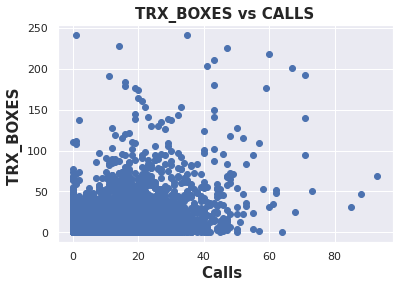

In [52]:
import matplotlib.pyplot as plt

df_hcp_month1 = df1.groupby(['RLYP_ID']).sum()
y = df_hcp_month1['TRX_BOXES']
x = df_hcp_month1['C0']

plt.xlabel('Calls ',fontweight="bold",size=15)
plt.ylabel('TRX_BOXES ',fontweight="bold",size=15)
  
plt.title('TRX_BOXES vs CALLS',fontweight ="bold",size=15)


plt.scatter(x, y)
plt.show()

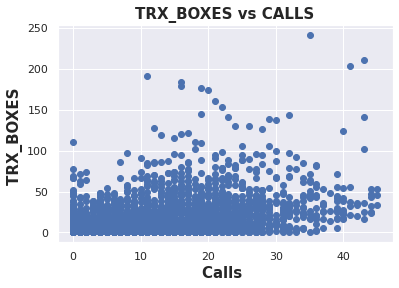

In [53]:
import matplotlib.pyplot as plt

df_hcp_month1 = df6.groupby(['RLYP_ID']).sum()
y = df_hcp_month1['TRX_BOXES']
x = df_hcp_month1['C0']

plt.xlabel('Calls ',fontweight="bold",size=15)
plt.ylabel('TRX_BOXES ',fontweight="bold",size=15)
  
plt.title('TRX_BOXES vs CALLS',fontweight ="bold",size=15)


plt.scatter(x, y)
plt.show()

# Prediction

## Baseline Random Forest Model

data[['MONTH', 'Sales1', 'Sales2', 'Sales3',
       'C0', 'C1', 'C2', 'C3', 'S0', 'S1', 'S2', 'S3', 'E0', 'E1', 'E2', 'E3', 'SP0',
       'SP1', 'SP2', 'SP3']].sum()

data.isnull().sum()

In [54]:
# data.MONTH = data.MONTH.astype(str)
# data['MONTH'] = data['MONTH'].apply(lambda x:x.zfill(2))
# data.YEAR = data.YEAR.astype(str)
# data['YEAR_MONTH'] = data['YEAR'] + data['MONTH']
# data.YEAR_MONTH = data.YEAR_MONTH.astype(np.int64)
# data.YEAR = data.YEAR.astype(np.int64)
# data.MONTH = data.MONTH.astype(np.int64)
# data = data.sort_values(by=['YEAR_MONTH'])
#data1 = data[data['YEAR']==2017]
#data1 = data1.sort_values(by=['YEAR_MONTH'])
#x_train_old = data1[['MONTH', 'Sales1', 'Sales2', 'Sales3','C0', 'C1', 'C2', 'C3', 'S0', 'S1', 'S2', 'S3', 'E0', 'E1', 'E2', 'E3', 'SP0','SP1', 'SP2', 'SP3']]
#y_train_old = data1['TRX_BOXES']

In [55]:
data = data.merge(Dim_customer_with_spec[['RLYP_ID','SPECIALTY GROUP']],on=['RLYP_ID'],how='left')
data1 = data.copy()

In [56]:
data1.head(2)

,Unnamed: 0,RLYP_ID,YEAR,MONTH,SALES_COUNT,NRX_BOXES,TRX_BOXES,CALLS_COUNT,QUANTITY_SHIPPED,SAMPLE_COUNT,EVENT_COUNT,SP_COUNT,Sales1,Sales2,Sales3,Sales4,Sales5,Sales6,Sales7,Sales8,C0,C1,C2,C3,C4,C5,C6,C7,C8,S0,S1,S2,S3,S4,S5,S6,S7,S8,E0,E1,E2,E3,E4,E5,E6,E7,E8,SP0,SP1,SP2,SP3,SP4,SP5,SP6,SP7,SP8,SP9,SP10,SP11,SP12,SALES_FLAG,SPECIALTY GROUP
0,4,100000039,2017,1,4,0.0,4.0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,NEPH
1,5,100000039,2017,2,4,1.0,4.0,1,12,1,0,0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0,0,0,0,0,0,0,0,12,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,NEPH


In [57]:
count = 0
for rlypid in data1.RLYP_ID.unique():
  datatemp = data1[data1['RLYP_ID']==rlypid]
  if(len(datatemp)<6):
    print(rlypid)
    count += 1
    if(count>5):
      break

100000057
100000110
100000298
100000567
100000928
100001064


In [58]:
data1[data1['RLYP_ID']==100022626]

,Unnamed: 0,RLYP_ID,YEAR,MONTH,SALES_COUNT,NRX_BOXES,TRX_BOXES,CALLS_COUNT,QUANTITY_SHIPPED,SAMPLE_COUNT,EVENT_COUNT,SP_COUNT,Sales1,Sales2,Sales3,Sales4,Sales5,Sales6,Sales7,Sales8,C0,C1,C2,C3,C4,C5,C6,C7,C8,S0,S1,S2,S3,S4,S5,S6,S7,S8,E0,E1,E2,E3,E4,E5,E6,E7,E8,SP0,SP1,SP2,SP3,SP4,SP5,SP6,SP7,SP8,SP9,SP10,SP11,SP12,SALES_FLAG,SPECIALTY GROUP
10940,27180,100022626,2017,1,0,0.0,0.0,1,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NEPH
10941,27181,100022626,2017,3,1,1.0,1.0,1,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,NEPH
10942,27182,100022626,2017,9,0,0.0,0.0,0,0,0,6,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,6,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NEPH
10943,27183,100022626,2017,10,0,0.0,0.0,1,0,0,0,0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,6,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NEPH
10944,27184,100022626,2017,11,0,0.0,0.0,1,0,0,0,0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1,1,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,6,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NEPH


In [59]:
list1 = []
list2 = []
list3 = []
unk_year = list(np.sort(data1.YEAR.unique()))
unk_month = list(np.sort(data1.MONTH.unique()))
for rlypid in tqdm(data1.RLYP_ID.unique()):
  for y in unk_year:
    for m in unk_month:
      list1.append(rlypid)
      list2.append(y)
      list3.append(m)
data1temp = pd.DataFrame()
data1temp['RLYP_ID'] = list1
data1temp['YEAR'] = list2
data1temp['MONTH'] = list3

  0%|          | 0/4406 [00:00<?, ?it/s]

In [60]:
data2temp = data1temp.merge(data1,on=['RLYP_ID','YEAR','MONTH'],how='left')
print(data2temp[['TRX_BOXES','C0','S0', 'E0','SP0']].isnull().sum())
data2temp[['TRX_BOXES','C0','S0', 'E0','SP0']] = data2temp[['TRX_BOXES','C0','S0', 'E0','SP0']].fillna(0)
print(data2temp[['TRX_BOXES','C0','S0', 'E0','SP0']].isnull().sum())
data1 = data2temp.copy()

TRX_BOXES    13565
C0           13565
S0           13565
E0           13565
SP0          13565
dtype: int64
TRX_BOXES    0
C0           0
S0           0
E0           0
SP0          0
dtype: int64


In [61]:
#data1[data1['RLYP_ID']==100022626]

In [62]:
data1 = data1.sort_values(['YEAR','MONTH'])
data1[['Sales1']] = data1.groupby(['RLYP_ID']).shift(1)[['TRX_BOXES']].fillna(0)
data1[['Sales2']] = data1.groupby(['RLYP_ID']).shift(2)[['TRX_BOXES']].fillna(0)
data1[['Sales3']] = data1.groupby(['RLYP_ID']).shift(3)[['TRX_BOXES']].fillna(0)
data1[['C1','S1','E1','SP1']] = data1.groupby(['RLYP_ID']).shift(1)[['C0','S0','E0','SP0']].fillna(0)
data1[['C2','S2','E2','SP2']] = data1.groupby(['RLYP_ID']).shift(2)[['C0','S0','E0','SP0']].fillna(0)
data1[['C3','S3','E3','SP3']] = data1.groupby(['RLYP_ID']).shift(3)[['C0','S0','E0','SP0']].fillna(0)

In [63]:
data1[data1['RLYP_ID']==100022626]

,RLYP_ID,YEAR,MONTH,Unnamed: 0,SALES_COUNT,NRX_BOXES,TRX_BOXES,CALLS_COUNT,QUANTITY_SHIPPED,SAMPLE_COUNT,EVENT_COUNT,SP_COUNT,Sales1,Sales2,Sales3,Sales4,Sales5,Sales6,Sales7,Sales8,C0,C1,C2,C3,C4,C5,C6,C7,C8,S0,S1,S2,S3,S4,S5,S6,S7,S8,E0,E1,E2,E3,E4,E5,E6,E7,E8,SP0,SP1,SP2,SP3,SP4,SP5,SP6,SP7,SP8,SP9,SP10,SP11,SP12,SALES_FLAG,SPECIALTY GROUP
13932,100022626,2017,1,27180.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NEPH
13933,100022626,2017,2,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,0.0,1.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
13934,100022626,2017,3,27181.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,NEPH
13935,100022626,2017,4,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,1.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,0.0,1.0,0.0,1.0,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
13936,100022626,2017,5,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,0.0,1.0,0.0,NaN,NaN,NaN,NaN,NaN,0.0,0.0,1.0,0.0,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
13937,100022626,2017,6,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,0.0,0.0,1.0,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,1.0,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
13938,100022626,2017,7,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
13939,100022626,2017,8,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
13940,100022626,2017,9,27182.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NEPH
13941,100022626,2017,10,27183.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NEPH


In [64]:
#len(data1temp)

In [65]:
len(data1.RLYP_ID.unique())

4406

In [66]:
len(data1)

52872

In [67]:
len(data1)

52872

In [68]:
4414*12

52968

In [69]:
# tempdf1 = data1[data1['RLYP_ID']==100035728]
# tempdf1

In [70]:
#temp1 = list(tempdf1['C0'])
#temp1

In [71]:
# def performCarryOver(tempdf,mask,n):
#     #n = len(tempdf)
#     #for col in ['C0', 'C1', 'C2', 'C3', 'S0', 'S1', 'S2', 'S3', 'E0', 'E1', 'E2', 'E3', 'SP0','SP1', 'SP2', 'SP3']:
#     tempdf1 = dataym.merge(tempdf,on=['YEAR','MONTH'],how='left')
#     tempdf1.fillna(0,inplace=True)
#     n = len(tempdf1)
#     #assert(n==12)
#     for col in ['C0', 'S0', 'E0', 'SP0']:
#         if((tempdf1[col] == 0).all()):
#             pass
#         else:
#             tempdf1[col] = list(np.convolve(mask,tempdf1[col]))[:n]
#     #print(tempdf1)
#     tempdf2 = tempdf[['YEAR','MONTH']].merge(tempdf1,on=['YEAR','MONTH'],how='left')
#     #assert(len(tempdf2)==len(tempdf))
#     return tempdf2

In [72]:
def performCarryOver(tempdf,mask,n):
    #n = len(tempdf)
    #for col in ['C0', 'C1', 'C2', 'C3', 'S0', 'S1', 'S2', 'S3', 'E0', 'E1', 'E2', 'E3', 'SP0','SP1', 'SP2', 'SP3']:
    n = 12
    for col in ['C0', 'S0', 'E0', 'SP0']:
        if((tempdf[col] == 0).all()):
            pass
        else:
            tempdf[col] = list(np.convolve(mask,tempdf[col]))[:n]
    return tempdf

In [73]:
def performCarryOver_new(tempdf,mask,n,colList):
    #n = len(tempdf)
    #for col in ['C0', 'C1', 'C2', 'C3', 'S0', 'S1', 'S2', 'S3', 'E0', 'E1', 'E2', 'E3', 'SP0','SP1', 'SP2', 'SP3']:
    n = 12
    for col in colList:
        if((tempdf[col] == 0).all()):
            pass
        else:
            tempdf[col] = list(np.convolve(mask,tempdf[col]))[:n]
    return tempdf

In [74]:
def performCarryOver_1(tempdf1,mask,n):
    for col in ['C0', 'S0', 'E0', 'SP0']:
        # if((tempdf1[col] == 0).all()):
        #     pass
        # else:
        tlist1 = np.zeros(12)
        tlist1[tempdf1['MONTH']-1] = tempdf1[col]
        ctlist1 = np.array(np.convolve(mask,tlist1))[:12]
        tempdf1[col] =  ctlist1[tempdf1['MONTH']-1]      
    return tempdf1

In [75]:
length = 3
strength = 0.5
init = 1
mask = [init]
for i in range(length-1):
    init *= strength
    mask.append(init)
listdfs = []
for unk_id in tqdm(data1.RLYP_ID.unique()):
    temp1 = data1[data1['RLYP_ID']==unk_id]
    listdfs.append(performCarryOver(temp1,mask,len(temp1)))
carryoverdata = pd.concat(listdfs,axis=0)    

  0%|          | 0/4406 [00:00<?, ?it/s]

In [76]:
carryoverdata.head(1)

,RLYP_ID,YEAR,MONTH,Unnamed: 0,SALES_COUNT,NRX_BOXES,TRX_BOXES,CALLS_COUNT,QUANTITY_SHIPPED,SAMPLE_COUNT,EVENT_COUNT,SP_COUNT,Sales1,Sales2,Sales3,Sales4,Sales5,Sales6,Sales7,Sales8,C0,C1,C2,C3,C4,C5,C6,C7,C8,S0,S1,S2,S3,S4,S5,S6,S7,S8,E0,E1,E2,E3,E4,E5,E6,E7,E8,SP0,SP1,SP2,SP3,SP4,SP5,SP6,SP7,SP8,SP9,SP10,SP11,SP12,SALES_FLAG,SPECIALTY GROUP
0,100000039,2017,1,4.0,4.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,NEPH


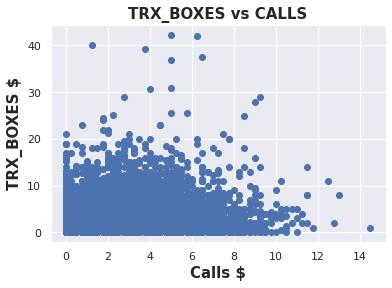

In [77]:
import matplotlib.pyplot as plt


y = carryoverdata['TRX_BOXES']
#y = carryoverdata['TRX_BOXES']
x = carryoverdata['C0']

plt.xlabel('Calls $',fontweight="bold",size=15)
plt.ylabel('TRX_BOXES $',fontweight="bold",size=15)
  
plt.title('TRX_BOXES vs CALLS',fontweight ="bold",size=15)


plt.scatter(x, y)
plt.show()

In [78]:
for col in ['TRX_BOXES','Sales1','Sales2','Sales2']:
  carryoverdata[col] *= 1#3000
  data1[col] *= 1#3000

In [79]:
carryoverdata[carryoverdata['RLYP_ID']==100022626]

,RLYP_ID,YEAR,MONTH,Unnamed: 0,SALES_COUNT,NRX_BOXES,TRX_BOXES,CALLS_COUNT,QUANTITY_SHIPPED,SAMPLE_COUNT,EVENT_COUNT,SP_COUNT,Sales1,Sales2,Sales3,Sales4,Sales5,Sales6,Sales7,Sales8,C0,C1,C2,C3,C4,C5,C6,C7,C8,S0,S1,S2,S3,S4,S5,S6,S7,S8,E0,E1,E2,E3,E4,E5,E6,E7,E8,SP0,SP1,SP2,SP3,SP4,SP5,SP6,SP7,SP8,SP9,SP10,SP11,SP12,SALES_FLAG,SPECIALTY GROUP
13932,100022626,2017,1,27180.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NEPH
13933,100022626,2017,2,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,0.50,1.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
13934,100022626,2017,3,27181.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.25,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,NEPH
13935,100022626,2017,4,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,1.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,0.50,1.0,0.0,1.0,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
13936,100022626,2017,5,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,0.0,1.0,0.0,NaN,NaN,NaN,NaN,NaN,0.25,0.0,1.0,0.0,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
13937,100022626,2017,6,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,0.0,0.0,1.0,NaN,NaN,NaN,NaN,NaN,0.00,0.0,0.0,1.0,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
13938,100022626,2017,7,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,0.00,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
13939,100022626,2017,8,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,0.00,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
13940,100022626,2017,9,27182.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NEPH
13941,100022626,2017,10,27183.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NEPH


In [80]:
carryoverdata1 = carryoverdata.copy()
#carryoverdata = carryoverdata.sort_values(['YEAR','MONTH'])
#carryoverdata1[['C1','S1','E1','SP1']] = carryoverdata.groupby(['RLYP_ID']).shift(1)[['C0','S0','E0','SP0']].fillna(0)
#carryoverdata1[['C2','S2','E2','SP2']] = carryoverdata.groupby(['RLYP_ID']).shift(2)[['C0','S0','E0','SP0']].fillna(0)
#carryoverdata1[['C3','S3','E3','SP3']] = carryoverdata.groupby(['RLYP_ID']).shift(3)[['C0','S0','E0','SP0']].fillna(0)

In [81]:
#carryoverdata1[carryoverdata1['RLYP_ID']==100035728]

In [82]:
#carryoverdata1 = carryoverdata1[carryoverdata1['TRX_BOXES']>0]
#carryoverdata1 = carryoverdata1[(carryoverdata1['C0']>0)]
#carryoverdata1 = carryoverdata1[(carryoverdata1['C0']>0)|(carryoverdata1['S0']>0)|(carryoverdata1['E0']>0)|(carryoverdata1['SP0']>0)]
#carryoverdata1 = carryoverdata1[(carryoverdata1['C0']>0)&(carryoverdata1['S0']>0)&(carryoverdata1['E0']>0)&(carryoverdata1['SP0']>0)]
#x_train_old = x_train_old[x_train_old['TRX_BOXES']>0]
#x_train_old = x_train_old[(x_train_old['C0']>0)|(x_train_old['S0']>0)|(x_train_old['E0']>0)|(x_train_old['SP0']>0)]


In [83]:
#cata

In [84]:
#x_train = carryoverdata1[['MONTH', 'Sales1', 'Sales2', 'Sales3','C0', 'C1', 'C2', 'C3', 'S0', 'S1', 'S2', 'S3', 'E0', 'E1', 'E2', 'E3', 'SP0','SP1', 'SP2', 'SP3']]
x_train = carryoverdata1[['MONTH', 'Sales1', 'Sales2', 'Sales3','C0', 'S0', 'E0', 'SP0']]
y_train = carryoverdata1['TRX_BOXES']
# c = 2
# s = 2
# e = 2
# sp = 2
# for col in ['C0','S0','E0', 'SP0']:
#   #x_train[col] = np.log(x_train[col]+0.01)
#   if col in ['C0']:
#     x_train[col] = 1-np.exp(-c*x_train[col])
#   elif col in ['S0']:
#     x_train[col] = 1-np.exp(-s*x_train[col])
#   elif col in ['E0']:
#     x_train[col] = 1-np.exp(-e*x_train[col])
#   elif col in ['SP0']:
#     x_train[col] = 1-np.exp(-sp*x_train[col])

In [85]:
#sns.displot(carryoverdata1, x="S0",discrete=True)

## Fitting the model

In [86]:
from sklearn.linear_model import LinearRegression

rf = LinearRegression()

#rf = RandomForestRegressor(random_state=123)

import xgboost
#rf = xgboost.XGBRegressor(n_estimators = 100, random_state=123)
from sklearn.ensemble import GradientBoostingRegressor
#rf = GradientBoostingRegressor(random_state=0)

rf.fit(x_train,y_train)

np.mean(y_train)

1.1557049730166185

## Train Test scores

In [87]:
print("TRAIN SCORE:")
pred = rf.predict(x_train)
print("R2 - ", np.round(r2_score(y_train, pred)*100,2))
print("MAE - ", np.round(mean_absolute_error(y_train, pred),2))
print("RMSE - ", np.round(np.sqrt(mean_squared_error(y_train, pred)),2))
print("MAPE - ", np.round(mean_absolute_error(y_train, pred)/np.mean(y_train),2))


# print("\n")

# print("TEST SCORE:")
# pred = rf.predict(x_test)
# print("R2 - ", np.round(r2_score(y_test, pred)*100,2))
# print("MAE - ", np.round(mean_absolute_error(y_test, pred),2))
# print("RMSE - ", np.round(np.sqrt(mean_squared_error(y_test, pred)),2))
# print("MAPE - ", np.round(mean_absolute_error(y_test, pred)/np.mean(y_test),2))

TRAIN SCORE:
R2 -  53.33
MAE -  0.84
RMSE -  1.41
MAPE -  0.73


In [88]:
#scorer(estimator, X, y)
def getr2(estimator,X,y):
  pred = estimator.predict(X)
  return r2_score(y, pred)*100
def getmae(estimator,X,y):
  pred = estimator.predict(X)
  return mean_absolute_error(y, pred)
def getrmse(estimator,X,y):
  pred = estimator.predict(X)
  return np.sqrt(mean_squared_error(y, pred))

from sklearn.model_selection import cross_val_score
cvr2 = np.mean(cross_val_score(rf, x_train, y_train, cv=3,scoring=getr2,n_jobs=-1))
cvmae = np.mean(cross_val_score(rf, x_train, y_train, cv=3,scoring=getmae,n_jobs=-1))
cvrmse = np.mean(cross_val_score(rf, x_train, y_train, cv=3,scoring=getrmse,n_jobs=-1))

print("CROSS VALIDATED SCORES:")
print("R2 - ", np.round(cvr2,2))
print("MAE - ", np.round(cvmae,2))
print("RMSE - ", np.round(cvrmse,2))
print("MAPE - ", np.round(cvmae/np.mean(y_train),2))

CROSS VALIDATED SCORES:
R2 -  52.65
MAE -  0.85
RMSE -  1.4
MAPE -  0.73


In [89]:
#list(rf.coef_)

In [90]:
#rf.intercept_

## Featrue Importance

In [91]:
feat_imp2 = pd.DataFrame({'FEATURE':x_train.columns,'Importance':rf.feature_importances_})
feat_imp2 = feat_imp2.sort_values(by='Importance',ascending=False)
#feat_imp2

AttributeError: ignored

In [ ]:
feat_imp2.to_excel("feature_imp_rf_model_mmm_nzdv_aoc_2017data_carover_logtrans.xlsx",index=False)

In [ ]:
feature_segments = pd.read_csv('feature_segments.csv')
#feature_segments

In [ ]:
feat_imp2 = feat_imp2.merge(feature_segments,on =['FEATURE'],how='left')
#feat_imp2

In [ ]:
feat_imp2_seg = feat_imp2.groupby(['SEGMENT']).sum()['Importance']
np.round(feat_imp2_seg,2)

In [ ]:
#np.sum(x_test['C0'])

In [ ]:
#data2 = data1.copy()
#datatemp = data1[data1['TRX_BOXES']>0]
#datatemp = datatemp[datatemp['C0']>0]
#data3 = datatemp.sample(frac = 0.05)


In [92]:
#data3.to_csv('5pdata_used_for_simulations.csv',index=False)

In [93]:
#data3 = pd.read_csv('5pdata_used_for_simulations.csv')

#data3 = datatemp.copy()

#data3_temp = data1.merge(carryoverdata1[['RLYP_ID','YEAR','MONTH']],on=['RLYP_ID','YEAR','MONTH'],how='inner')

data3 = data1.copy()

In [94]:
len(data1)

52872

In [95]:
len(carryoverdata)

52872

In [96]:
length = 3
strength = 0.5
init = 1
mask = [init]
for temp in range(length-1):
    init *= strength
    mask.append(init)

data3unkdocs = data3.RLYP_ID.unique()

## PREDICTION BY INCREASING CALLS

In [97]:
#trx_b*3000 = a* c*250 + b* s*60 + c* e + d* sp + k 

In [98]:
np.exp(np.log(5))

4.999999999999999

In [99]:
prediction = []
total_calls = []
per = []
#data2 = data1.copy()
#data3 = data2.sample(frac = 0.05)

#implement the carryover effect only by calls

for i in tqdm(np.arange(0,3,0.1)):
    data2 = data3.copy()
    #data2 = carryoverdata1.copy()
    #data2[['C0']] = data3[['C0']]
    per.append(i)
    
    ## incrementing the calls values by 2% 
    data2[['C0']] = data3[['C0']]+data3[['C0']]*i
    
    ## applying carry over effect on data2
    listdfs = []
    for unk_id in tqdm(data3unkdocs):
        temp1 = data2[data2['RLYP_ID']==unk_id]
        listdfs.append(performCarryOver(temp1,mask,len(temp1)))
        #listdfs.append(performCarryOver_new(temp1,mask,len(temp1),['C0']))
    carryoverdata2 = pd.concat(listdfs,axis=0)     
    
    ## computing the carryover effect of all other promotions by shifiting 
    
    #carryoverdata2 = carryoverdata2.sort_values(['YEAR','MONTH'])            
    ## applying log transform on each promo feature of carryover data

    # for col in ['C0','S0','E0', 'SP0']:
    #   carryoverdata2[col] = np.log(carryoverdata2[col]+0.01)

      # if col in ['C0']:
      #   carryoverdata2[col] = 1-np.exp(-c*carryoverdata2[col])
      # elif col in ['S0']:
      #   carryoverdata2[col] = 1-np.exp(-s*carryoverdata2[col])
      # elif col in ['E0']:
      #   carryoverdata2[col] = 1-np.exp(-e*carryoverdata2[col])
      # elif col in ['SP0']:
      #   carryoverdata2[col] = 1-np.exp(-sp*carryoverdata2[col])            
    
    #removing the zero trx boxes rows and retaining only records with one promotional channel 
    #carryoverdata2 = carryoverdata2[carryoverdata2['TRX_BOXES']>0]
    #carryoverdata2 = carryoverdata2[(carryoverdata2['C0']>0)]
    #carryoverdata2 = carryoverdata2[(carryoverdata2['C0']>0)|(carryoverdata2['S0']>0)|(carryoverdata2['E0']>0)|(carryoverdata2['SP0']>0)]
    
    #considering only the required features for training
    x_temp = carryoverdata2[['MONTH', 'Sales1', 'Sales2', 'Sales3','C0','S0', 'E0','SP0']]
    
    #adding the total trx predictions for all samples in data, total calls given or incremented
    prediction.append(np.sum(rf.predict(x_temp)))
    #prediction.append(np.sum(np.exp(rf.predict(x_temp))-0.01))
    total_calls.append(np.sum(data2['C0']))
    #del data2,carryoverdata2,x_temp,data3_temp
    #break

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/4406 [00:00<?, ?it/s]

  0%|          | 0/4406 [00:00<?, ?it/s]

  0%|          | 0/4406 [00:00<?, ?it/s]

  0%|          | 0/4406 [00:00<?, ?it/s]

  0%|          | 0/4406 [00:00<?, ?it/s]

  0%|          | 0/4406 [00:00<?, ?it/s]

  0%|          | 0/4406 [00:00<?, ?it/s]

  0%|          | 0/4406 [00:00<?, ?it/s]

  0%|          | 0/4406 [00:00<?, ?it/s]

  0%|          | 0/4406 [00:00<?, ?it/s]

  0%|          | 0/4406 [00:00<?, ?it/s]

  0%|          | 0/4406 [00:00<?, ?it/s]

  0%|          | 0/4406 [00:00<?, ?it/s]

  0%|          | 0/4406 [00:00<?, ?it/s]

  0%|          | 0/4406 [00:00<?, ?it/s]

  0%|          | 0/4406 [00:00<?, ?it/s]

  0%|          | 0/4406 [00:00<?, ?it/s]

  0%|          | 0/4406 [00:00<?, ?it/s]

  0%|          | 0/4406 [00:00<?, ?it/s]

  0%|          | 0/4406 [00:00<?, ?it/s]

  0%|          | 0/4406 [00:00<?, ?it/s]

  0%|          | 0/4406 [00:00<?, ?it/s]

  0%|          | 0/4406 [00:00<?, ?it/s]

  0%|          | 0/4406 [00:00<?, ?it/s]

  0%|          | 0/4406 [00:00<?, ?it/s]

  0%|          | 0/4406 [00:00<?, ?it/s]

  0%|          | 0/4406 [00:00<?, ?it/s]

  0%|          | 0/4406 [00:00<?, ?it/s]

  0%|          | 0/4406 [00:00<?, ?it/s]

  0%|          | 0/4406 [00:00<?, ?it/s]

In [101]:
df = pd.DataFrame({'INCREMENTAL PERCENTAGE INCREASE':per,'TOTAL_CALLS':total_calls,'PREDICTION_TRX':prediction})
df['PREVIOUS_CALLS'] = df.shift(1)['TOTAL_CALLS']
df['PREVIOUS_PREDICTION_TRX'] = df.shift(1)['PREDICTION_TRX']
df['MROI'] =  ((df['PREDICTION_TRX'] - df['PREVIOUS_PREDICTION_TRX'])*3000)/((df['TOTAL_CALLS']-df['PREVIOUS_CALLS'])*250)
df['MROI'] = df['MROI'].fillna(0)

In [106]:
df.tail(10)
#df.to_csv('calls_rf_model_full_data_carryover_exp_transform.csv',index=False)

,INCREMENTAL PERCENTAGE INCREASE,TOTAL_CALLS,PREDICTION_TRX,PREVIOUS_CALLS,PREVIOUS_PREDICTION_TRX,MROI
20,2.0,154770.0,73970.799528,149611.0,73327.481219,1.496379
21,2.1,159929.0,74614.117838,154770.0,73970.799528,1.496379
22,2.2,165088.0,75257.436148,159929.0,74614.117838,1.496379
23,2.3,170247.0,75900.754458,165088.0,75257.436148,1.496379
24,2.4,175406.0,76544.072767,170247.0,75900.754458,1.496379
25,2.5,180565.0,77187.391077,175406.0,76544.072767,1.496379
26,2.6,185724.0,77830.709387,180565.0,77187.391077,1.496379
27,2.7,190883.0,78474.027697,185724.0,77830.709387,1.496379
28,2.8,196042.0,79117.346006,190883.0,78474.027697,1.496379
29,2.9,201201.0,79760.664316,196042.0,79117.346006,1.496379


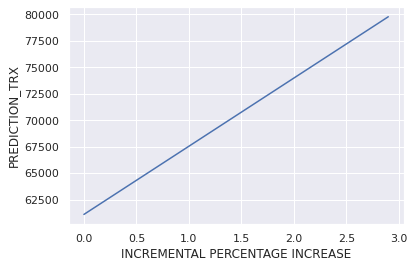

In [103]:
sns.lineplot(data=df, x="INCREMENTAL PERCENTAGE INCREASE", y="PREDICTION_TRX")
#sns.lineplot(data=df, x="PERCENTAGE INCREASE", y="PREDICTION_TRX")

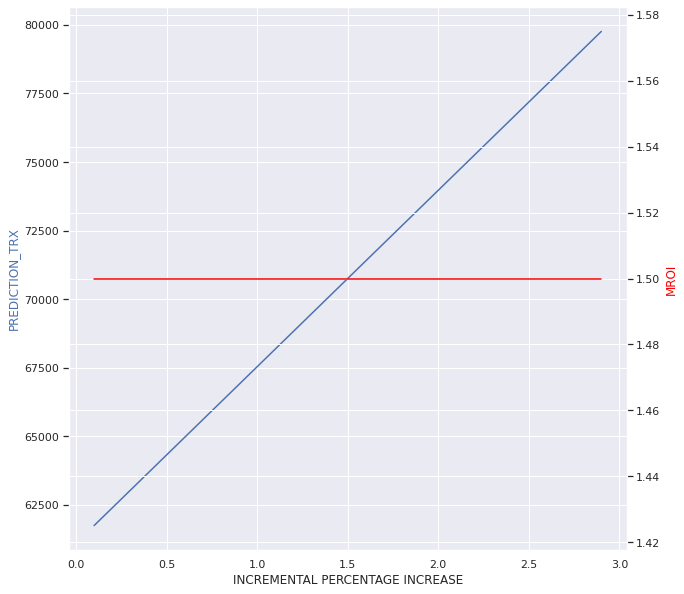

In [111]:
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (10,10)
x = df['INCREMENTAL PERCENTAGE INCREASE'][1:]
y = df['PREDICTION_TRX'][1:]
y1 = np.round(df['MROI'][1:],2)

fig, ax1 = plt.subplots()

ax2 = ax1.twinx()
ax1.plot(x, y)
ax2.plot(x, y1, color="red" )

ax1.set_xlabel('INCREMENTAL PERCENTAGE INCREASE')
ax1.set_ylabel('PREDICTION_TRX', color='b')
ax2.set_ylabel('MROI', color='red')
#plt.title("MROI, PREDICTION_TRX vs INC PERCENTAGE INCREASE")
plt.show()

In [ ]:
### decreasing calls

In [ ]:
from pandas.core.resample import f
prediction = []
total_calls = []
per = []
#data2 = data1.copy()
#data3 = data2.sample(frac = 0.05)

#implement the carryover effect only by calls

for i in tqdm(np.arange(0,1,0.1)):
    data2 = data3.copy()
    per.append(i)
    
    ## incrementing the calls values by 2% 
    data2[['C0']] = data3[['C0']]-data3[['C0']]*i

    data

    
    ## applying carry over effect on data2
    listdfs = []
    for unk_id in tqdm(data3unkdocs):
        temp1 = data2[data2['RLYP_ID']==unk_id]
        listdfs.append(performCarryOver(temp1,mask,len(temp1)))
    carryoverdata2 = pd.concat(listdfs,axis=0)     
    
    ## computing the carryover effect of all other promotions by shifiting 
    
    #carryoverdata2 = carryoverdata2.sort_values(['YEAR','MONTH'])            
    ## applying log transform on each promo feature of carryover data

    for col in ['C0','S0','E0', 'SP0']:
      if col in ['C0']:
        carryoverdata2[col] = 1-np.exp(-c*carryoverdata2[col])
      elif col in ['S0']:
        carryoverdata2[col] = 1-np.exp(-s*carryoverdata2[col])
      elif col in ['E0']:
        carryoverdata2[col] = 1-np.exp(-e*carryoverdata2[col])
      elif col in ['SP0']:
        carryoverdata2[col] = 1-np.exp(-sp*carryoverdata2[col])            
    
    #removing the zero trx boxes rows and retaining only records with one promotional channel 
    #carryoverdata2 = carryoverdata2[carryoverdata2['TRX_BOXES']>0]
    #carryoverdata2 = carryoverdata2[(carryoverdata2['C0']>0)]
    #carryoverdata2 = carryoverdata2[(carryoverdata2['C0']>0)|(carryoverdata2['S0']>0)|(carryoverdata2['E0']>0)|(carryoverdata2['SP0']>0)]
    
    #considering only the required features for training
    x_temp = carryoverdata2[['MONTH', 'Sales1', 'Sales2', 'Sales3','C0','S0', 'E0','SP0']]
    
    #adding the total trx predictions for all samples in data, total calls given or incremented
    prediction.append(np.sum(rf.predict(x_temp)))
    total_calls.append(np.sum(data2['C0']))
    #del data2,carryoverdata2,x_temp,data3_temp
    #break


df = pd.DataFrame({'INCREMENTAL PERCENTAGE INCREASE':per,'TOTAL_CALLS':total_calls,'PREDICTION_TRX':prediction})
df['PREVIOUS_CALLS'] = df.shift(1)['TOTAL_CALLS']
df['PREVIOUS_PREDICTION_TRX'] = df.shift(1)['PREDICTION_TRX']
df['MROI'] =  ((df['PREDICTION_TRX'] - df['PREVIOUS_PREDICTION_TRX'])*3000)/((df['TOTAL_CALLS']-df['PREVIOUS_CALLS'])*250)
df['MROI'] = df['MROI'].fillna(0)

# temparr1 = list(df['MROI'])
# temparr2 = list(df['MROI'])
# for i in range(2,len(temparr)):
#     temparr1[i] = (temparr2[i] + temparr2[i-1] + temparr2[i-2])/3

# df['MROI'] = temparr1
# runnavg = []
# runnsum = 0
# count = 1
# import math
# for ele in df['MROI']:
#     if math.isnan(ele):
#         ele = 0.0
#     runnsum+= ele
#     runnavg.append(runnsum/count)
#     count += 1  
# df['MROI'] = runnavg

In [ ]:
import matplotlib.pyplot as plt
x = df['INCREMENTAL PERCENTAGE INCREASE'][1:]
y = df['PREDICTION_TRX'][1:]
y1 = df['MROI'][1:]

fig, ax1 = plt.subplots()

ax2 = ax1.twinx()
ax1.plot(x, y)
ax2.plot(x, y1, color="red" )

ax1.set_xlabel('INCREMENTAL PERCENTAGE INCREASE')
ax1.set_ylabel('PREDICTION_TRX', color='b')
ax2.set_ylabel('MROI', color='red')
plt.title("MROI, PREDICTION_TRX vs INC PERCENTAGE INCREASE")
plt.show()

In [ ]:
df

## PREDICTION BY INCREASING SAMPLES

In [ ]:
from pandas.core.resample import f
prediction = []
total_calls = []
per = []
#data2 = data1.copy()
#data3 = data2.sample(frac = 0.05)

#implement the carryover effect only by calls


for i in tqdm(np.arange(0,3,0.1)):
    data2 = data3.copy()
    per.append(i)
    
    ## incrementing the calls values by 2% 
    data2[['S0']] = data3[['S0']]+data3[['S0']]*i
    
    ## applying carry over effect on data2
    listdfs = []
    for unk_id in tqdm(data3unkdocs):
        temp1 = data2[data2['RLYP_ID']==unk_id]
        listdfs.append(performCarryOver(temp1,mask,len(temp1)))
    carryoverdata2 = pd.concat(listdfs,axis=0)     
    
    ## computing the carryover effect of all other promotions by shifiting 
    
    #carryoverdata2 = carryoverdata2.sort_values(['YEAR','MONTH'])            
    ## applying log transform on each promo feature of carryover data

    for col in ['C0','S0','E0', 'SP0']:
      if col in ['C0']:
        carryoverdata2[col] = 1-np.exp(-c*carryoverdata2[col])
      elif col in ['S0']:
        carryoverdata2[col] = 1-np.exp(-s*carryoverdata2[col])
      elif col in ['E0']:
        carryoverdata2[col] = 1-np.exp(-e*carryoverdata2[col])
      elif col in ['SP0']:
        carryoverdata2[col] = 1-np.exp(-sp*carryoverdata2[col])            
    
    #removing the zero trx boxes rows and retaining only records with one promotional channel 
    carryoverdata2 = carryoverdata2[carryoverdata2['TRX_BOXES']>0]
    carryoverdata2 = carryoverdata2[(carryoverdata2['C0']>0)]
    #carryoverdata2 = carryoverdata2[(carryoverdata2['C0']>0)|(carryoverdata2['S0']>0)|(carryoverdata2['E0']>0)|(carryoverdata2['SP0']>0)]
    
    #considering only the required features for training
    x_temp = carryoverdata2[['MONTH', 'Sales1', 'Sales2', 'Sales3','C0','S0', 'E0','SP0']]
    
    #adding the total trx predictions for all samples in data, total calls given or incremented
    prediction.append(np.sum(rf.predict(x_temp)))
    #print(len(data2))
    data3_temp = data2[['RLYP_ID','YEAR','MONTH','C0','S0','E0','SP0']].merge(carryoverdata2[['RLYP_ID','YEAR','MONTH']],on=['RLYP_ID','YEAR','MONTH'],how='inner')
    #print(len(data3_temp))
    total_calls.append(np.sum(data3_temp['S0']))
    del data2,carryoverdata2,x_temp,data3_temp
    #break


df = pd.DataFrame({'INCREMENTAL PERCENTAGE INCREASE':per,'TOTAL_CALLS':total_calls,'PREDICTION_TRX':prediction})
df['PREVIOUS_CALLS'] = df.shift(1)['TOTAL_CALLS']
df['PREVIOUS_PREDICTION_TRX'] = df.shift(1)['PREDICTION_TRX']
df['MROI'] =  ((df['PREDICTION_TRX'] - df['PREVIOUS_PREDICTION_TRX'])*3000)/((df['TOTAL_CALLS']-df['PREVIOUS_CALLS'])*250)
df['MROI'] = df['MROI'].fillna(0)

# temparr1 = list(df['MROI'])
# temparr2 = list(df['MROI'])
# for i in range(2,len(temparr)):
#     temparr1[i] = (temparr2[i] + temparr2[i-1] + temparr2[i-2])/3

# df['MROI'] = temparr1
# runnavg = []
# runnsum = 0
# count = 1
# import math
# for ele in df['MROI']:
#     if math.isnan(ele):
#         ele = 0.0
#     runnsum+= ele
#     runnavg.append(runnsum/count)
#     count += 1  
# df['MROI'] = runnavg

In [ ]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.lineplot(data=df, x="INCREMENTAL PERCENTAGE INCREASE", y="PREDICTION_TRX").set_title("PREDICTION_TRX vs PERCENTAGE INCREASE IN SAMPLES")

In [ ]:
#df.columns
#df.to_csv('samples_rf_model_full_data_carryover_exp_transform.csv',index=False)

In [ ]:
import matplotlib.pyplot as plt
x = df['INCREMENTAL PERCENTAGE INCREASE'][1:]
y = df['PREDICTION_TRX'][1:]
y1 = df['MROI'][1:]

fig, ax1 = plt.subplots()

ax2 = ax1.twinx()
ax1.plot(x, y)
ax2.plot(x, y1, color="red" )

ax1.set_xlabel('INCREMENTAL PERCENTAGE INCREASE')
ax1.set_ylabel('PREDICTION_TRX', color='b')
ax2.set_ylabel('MROI', color='red')
plt.title("MROI, PREDICTION_TRX vs INC PERCENTAGE INCREASE")
plt.show()

## PREDICTION BY INCREASING EVENTS

In [ ]:
from pandas.core.resample import f
prediction = []
total_calls = []
per = []
#data2 = data1.copy()
#data3 = data2.sample(frac = 0.05)

#implement the carryover effect only by calls


data3unkdocs = data2.RLYP_ID.unique()

for i in tqdm(np.arange(0,3,0.1)):
    data2 = data3.copy()
    per.append(i)
    
    ## incrementing the calls values by 2% 
    data2[['E0']] = data3[['E0']]+data3[['E0']]*i
    
    ## applying carry over effect on data2
    listdfs = []
    for unk_id in tqdm(data3unkdocs):
        temp1 = data2[data2['RLYP_ID']==unk_id]
        listdfs.append(performCarryOver(temp1,mask,len(temp1)))
    carryoverdata2 = pd.concat(listdfs,axis=0)     
    
    ## computing the carryover effect of all other promotions by shifiting 
    
    #carryoverdata2 = carryoverdata2.sort_values(['YEAR','MONTH'])            
    ## applying log transform on each promo feature of carryover data

    for col in ['C0','S0','E0', 'SP0']:
      if col in ['C0']:
        carryoverdata2[col] = 1-np.exp(-c*carryoverdata2[col])
      elif col in ['S0']:
        carryoverdata2[col] = 1-np.exp(-s*carryoverdata2[col])
      elif col in ['E0']:
        carryoverdata2[col] = 1-np.exp(-e*carryoverdata2[col])
      elif col in ['SP0']:
        carryoverdata2[col] = 1-np.exp(-sp*carryoverdata2[col])            
    
    #removing the zero trx boxes rows and retaining only records with one promotional channel 
    carryoverdata2 = carryoverdata2[carryoverdata2['TRX_BOXES']>0]
    carryoverdata2 = carryoverdata2[(carryoverdata2['C0']>0)]
    #carryoverdata2 = carryoverdata2[(carryoverdata2['C0']>0)|(carryoverdata2['S0']>0)|(carryoverdata2['E0']>0)|(carryoverdata2['SP0']>0)]
    
    #considering only the required features for training
    x_temp = carryoverdata2[['MONTH', 'Sales1', 'Sales2', 'Sales3','C0','S0', 'E0','SP0']]
    
    #adding the total trx predictions for all samples in data, total calls given or incremented
    prediction.append(np.sum(rf.predict(x_temp)))
    #print(len(data2))
    data3_temp = data2[['RLYP_ID','YEAR','MONTH','C0','S0','E0','SP0']].merge(carryoverdata2[['RLYP_ID','YEAR','MONTH']],on=['RLYP_ID','YEAR','MONTH'],how='inner')
    #print(len(data3_temp))
    total_calls.append(np.sum(data3_temp['E0']))
    del data2,carryoverdata2,x_temp,data3_temp


df = pd.DataFrame({'INCREMENTAL PERCENTAGE INCREASE':per,'TOTAL_CALLS':total_calls,'PREDICTION_TRX':prediction})
df['PREVIOUS_CALLS'] = df.shift(1)['TOTAL_CALLS']
df['PREVIOUS_PREDICTION_TRX'] = df.shift(1)['PREDICTION_TRX']
df['MROI'] =  ((df['PREDICTION_TRX'] - df['PREVIOUS_PREDICTION_TRX'])*3000)/((df['TOTAL_CALLS']-df['PREVIOUS_CALLS'])*250)
df['MROI'] = df['MROI'].fillna(0)

# temparr1 = list(df['MROI'])
# temparr2 = list(df['MROI'])
# for i in range(2,len(temparr)):
#     temparr1[i] = (temparr2[i] + temparr2[i-1] + temparr2[i-2])/3

# df['MROI'] = temparr1
# runnavg = []
# runnsum = 0
# count = 1
# import math
# for ele in df['MROI']:
#     if math.isnan(ele):
#         ele = 0.0
#     runnsum+= ele
#     runnavg.append(runnsum/count)
#     count += 1  
# df['MROI'] = runnavg

In [ ]:
#df.to_csv('events_rf_model_full_data_carryover_exp_transform.csv',index=False)

In [ ]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.lineplot(data=df, x="INCREMENTAL PERCENTAGE INCREASE", y="PREDICTION_TRX").set_title("PREDICTION_TRX vs PERCENTAGE INCREASE IN EVENTS")

In [ ]:
import matplotlib.pyplot as plt
x = df['INCREMENTAL PERCENTAGE INCREASE'][1:]
y = df['PREDICTION_TRX'][1:]
y1 = df['MROI'][1:]

fig, ax1 = plt.subplots()

ax2 = ax1.twinx()
ax1.plot(x, y)
ax2.plot(x, y1, color="red" )

ax1.set_xlabel('INCREMENTAL PERCENTAGE INCREASE')
ax1.set_ylabel('PREDICTION_TRX', color='b')
ax2.set_ylabel('MROI', color='red')
plt.title("MROI, PREDICTION_TRX vs INC PERCENTAGE INCREASE")
plt.show()

## PREDICTION BY INCREASING SPEAKER PROGRAMS

In [ ]:
from pandas.core.resample import f
prediction = []
total_calls = []
per = []
#data2 = data1.copy()
#data3 = data2.sample(frac = 0.05)

#implement the carryover effect only by calls


for i in tqdm(np.arange(0,4,1)):
    data2 = data3.copy()
    per.append(i)
    
    ## incrementing the calls values by 2% 
    data2[['SP0']] = data3[['SP0']]+data3[['SP0']]*i
    
    ## applying carry over effect on data2
    listdfs = []
    for unk_id in tqdm(data3unkdocs):
        temp1 = data2[data2['RLYP_ID']==unk_id]
        listdfs.append(performCarryOver(temp1,mask,len(temp1)))
    carryoverdata2 = pd.concat(listdfs,axis=0)     
    
    ## computing the carryover effect of all other promotions by shifiting 
    
    #carryoverdata2 = carryoverdata2.sort_values(['YEAR','MONTH'])            
    ## applying log transform on each promo feature of carryover data

    for col in ['C0','S0','E0', 'SP0']:
      if col in ['C0']:
        carryoverdata2[col] = 1-np.exp(-c*carryoverdata2[col])
      elif col in ['S0']:
        carryoverdata2[col] = 1-np.exp(-s*carryoverdata2[col])
      elif col in ['E0']:
        carryoverdata2[col] = 1-np.exp(-e*carryoverdata2[col])
      elif col in ['SP0']:
        carryoverdata2[col] = 1-np.exp(-sp*carryoverdata2[col])            
    
    #removing the zero trx boxes rows and retaining only records with one promotional channel 
    carryoverdata2 = carryoverdata2[carryoverdata2['TRX_BOXES']>0]
    carryoverdata2 = carryoverdata2[(carryoverdata2['C0']>0)]
    #carryoverdata2 = carryoverdata2[(carryoverdata2['C0']>0)|(carryoverdata2['S0']>0)|(carryoverdata2['E0']>0)|(carryoverdata2['SP0']>0)]
    
    #considering only the required features for training
    x_temp = carryoverdata2[['MONTH', 'Sales1', 'Sales2', 'Sales3','C0','S0', 'E0','SP0']]
    
    #adding the total trx predictions for all samples in data, total calls given or incremented
    prediction.append(np.sum(rf.predict(x_temp)))
    #print(len(data2))
    data3_temp = data2[['RLYP_ID','YEAR','MONTH','C0','S0','E0','SP0']].merge(carryoverdata2[['RLYP_ID','YEAR','MONTH']],on=['RLYP_ID','YEAR','MONTH'],how='inner')
    #print(len(data3_temp))
    total_calls.append(np.sum(data3_temp['SP0']))
    del data2,carryoverdata2,x_temp,data3_temp


df = pd.DataFrame({'INCREMENTAL PERCENTAGE INCREASE':per,'TOTAL_CALLS':total_calls,'PREDICTION_TRX':prediction})
df['PREVIOUS_CALLS'] = df.shift(1)['TOTAL_CALLS']
df['PREVIOUS_PREDICTION_TRX'] = df.shift(1)['PREDICTION_TRX']
df['MROI'] =  ((df['PREDICTION_TRX'] - df['PREVIOUS_PREDICTION_TRX'])*3000)/((df['TOTAL_CALLS']-df['PREVIOUS_CALLS'])*250)
df['MROI'] = df['MROI'].fillna(0)

# temparr1 = list(df['MROI'])
# temparr2 = list(df['MROI'])
# for i in range(2,len(temparr)):
#     temparr1[i] = (temparr2[i] + temparr2[i-1] + temparr2[i-2])/3

# df['MROI'] = temparr1
# runnavg = []
# runnsum = 0
# count = 1
# import math
# for ele in df['MROI']:
#     if math.isnan(ele):
#         ele = 0.0
#     runnsum+= ele
#     runnavg.append(runnsum/count)
#     count += 1  
# df['MROI'] = runnavg

In [ ]:
#df.to_csv('speaker_programs_rf_model_full_data_carryover_exp_transform.csv',index=False)

In [ ]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.lineplot(data=df, x="INCREMENTAL PERCENTAGE INCREASE", y="PREDICTION_TRX").set_title("PREDICTION_TRX vs PERCENTAGE INCREASE IN SPEAKER PROGRAMS")

In [ ]:
import matplotlib.pyplot as plt
x = df['INCREMENTAL PERCENTAGE INCREASE']
y = df['PREDICTION_TRX']
y1 = df['MROI']

fig, ax1 = plt.subplots()

ax2 = ax1.twinx()
ax1.plot(x, y)
ax2.plot(x, y1, color="red" )

ax1.set_xlabel('INCREMENTAL PERCENTAGE INCREASE')
ax1.set_ylabel('PREDICTION_TRX', color='b')
ax2.set_ylabel('MROI', color='red')
plt.title("MROI, PREDICTION_TRX vs INC PERCENTAGE INCREASE")
plt.show()